In [43]:
import argparse
import boto3
import pandas as pd
import s3fs
import numpy as np 
import io 
import pyarrow as pa 
import pyarrow.parquet as pq
import duckdb
import os
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight

In [44]:
def execute_sql_return_df(sql_text): 
    df = con.execute(sql_text).fetchdf()
    return df

In [51]:
def execute_sql_print_result(sql_text): 
    results = con.execute(sql_text).fetchall()
    print(results)

In [46]:
con = duckdb.connect('../hmda.duckdb')

In [47]:
text = '''
select distinct action_taken_category
from hmda_raw
'''
df = execute_sql_print_result(text)

[('Fallout',), ('Origination',), ('Preapproval - Denial',), ('nan',), ('Preapproval - Approved not accepted',), ('Denied',), ('Purchased - Secondary Market',)]


In [48]:
# declaring variables
chunksize = 500_000
target_column = "action_taken_category"
positive_class_label = "Origination"
negative_class_label = 'Denied'
classes = np.array([0, 1])

In [49]:
# # Create new table and prefilter
# con.execute('''
# create table hmda_target
# as 
# select *
# from hmda_raw
# where action_taken_category in ('Origination', 'Denied')
# ''')

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [52]:
text = '''
select count(*)
from hmda_target
'''
execute_sql_print_result(text)

[(33288138,)]


In [54]:
# # Assign random float to each row
# con.execute('''
# update hmda_target set split = random() where split is null;
# ''')

In [63]:
# validate targets
text = '''
select distinct action_taken_category
from hmda_target
'''
execute_sql_print_result(text)

[('Denied',), ('Origination',)]


In [69]:
# --- Feature selection ---
categorical_features = [
    "loan_type_category", "loan_purpose_category", "lien_status_category",
    "applicant_sex_category", "applicant_race_1_category", "applicant_ethnicity_1_category",
    "occupancy_type_category", "manufactured_home_secured_property_type_category",
    "reverse_mortgage_category", "open_end_line_of_credit_category",
    "balloon_payment_category", "interest_only_payment_category",
    "negative_amortization_category"
]
numerical_features = [
    "loan_amount", "loan_to_value_ratio", "combined_loan_to_value_ratio",
    "effective_ltv", "income", "debt_to_income_ratio",
    "tract_minority_population_percent", "tract_to_msa_income_percentage",
    "tract_owner_occupied_units", "tract_median_age_of_housing_units"
]

In [56]:
## Helper functions
def clean_column(df, col):
    """Cleans a column by converting missing-like strings to NaN."""
    if col in df.columns:
        df[col] = df[col].replace(
            ["", ".", "-", "Exempt", "NA", "NaN", "nan", "null", "None", "n/a"],
            np.nan
        )
    return df

def convert_percent_string(val):
    try:
        if isinstance(val, str):
            return float(val.strip('%'))
        return val
    except:
        return np.nan

In [57]:
# Preprocessing helper
def preprocess_chunk(df):
    """Cleans and preprocesses the chunk."""
    # Handle missing and dirty values
    for col in categorical_features + numerical_features + [target_column]:
        df = clean_column(df, col)

    # Convert string numerical fields
    if "debt_to_income_ratio" in df.columns:
        df["debt_to_income_ratio"] = df["debt_to_income_ratio"].apply(convert_percent_string)
    return df

In [80]:
# --- Preprocessing Pipelines ---
num_pipe = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())
cat_pipe = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
)

preprocessor = ColumnTransformer([
    ("num", num_pipe, numerical_features),
    ("cat", cat_pipe, categorical_features)
])

In [81]:
# --- Model ---
clf = SGDClassifier(loss="log_loss", penalty="l2", max_iter=1000, learning_rate="optimal")

In [82]:
## Validation set
val_df = con.execute(f"""
    SELECT {', '.join(categorical_features + numerical_features + [target_column])}
    FROM hmda_target
    WHERE split >= 0.98 AND split < 0.99
      AND {target_column} IN ('{positive_class_label}', '{negative_class_label}')
""").fetchdf()

In [83]:
# Process validation set
val_df = preprocess_chunk(val_df)
val_df["target"] = (val_df[target_column] == positive_class_label).astype(int)
X_val = val_df[categorical_features + numerical_features]
y_val = val_df["target"]

/var/folders/88/q8wq3ss94k3bvmkq1j1f_j0w0000gn/T/ipykernel_30017/1596352303.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(


In [84]:
# first training chunk to fit encoder
first_chunk = con.execute(f"""
select {', '.join(categorical_features + numerical_features + [target_column])}
from hmda_target
where split < 0.98
limit {chunksize}
""").fetchdf()

In [85]:
# process first chunk
first_chunk = preprocess_chunk(first_chunk)
first_chunk['target'] = (first_chunk[target_column] == positive_class_label).astype(int)
X_first = first_chunk[categorical_features + numerical_features]
y_first = first_chunk['target']

/var/folders/88/q8wq3ss94k3bvmkq1j1f_j0w0000gn/T/ipykernel_30017/1596352303.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(


In [86]:
# compute class weights
class_weights = compute_class_weight("balanced", classes=classes, y=y_first)
weight_dict = dict(zip(classes, class_weights))

In [87]:
# fit preprocessor and model
X_first_proc = preprocessor.fit_transform(X_first)
clf.partial_fit(X_first_proc, y_first, classes=classes, sample_weight=y_first.map(weight_dict))

/Users/charlesclark/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['combined_loan_to_value_ratio' 'debt_to_income_ratio']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


SGDClassifier(loss='log_loss')

In [88]:
# Validate after first chunk
X_val_proc = preprocessor.transform(X_val)
val_pred = clf.predict(X_val_proc)
print("\n📊 Validation after first chunk:")
print(classification_report(y_val, val_pred))

/Users/charlesclark/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['combined_loan_to_value_ratio' 'debt_to_income_ratio']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(



📊 Validation after first chunk:
              precision    recall  f1-score   support

           0       0.16      0.98      0.28     53889
           1       0.88      0.02      0.04    279410

    accuracy                           0.18    333299
   macro avg       0.52      0.50      0.16    333299
weighted avg       0.76      0.18      0.08    333299



In [89]:
# Train on remaining chunks
offset = chunksize
while True: 
    query = f"""
    select {', '.join(categorical_features + numerical_features + [target_column])}
    from hmda_target
    where split < 0.98
    limit {chunksize} offset {offset}
    """
    chunk = con.execute(query).fetchdf()
    if chunk.empty: 
        break 
    
    chunk = preprocess_chunk(chunk)
    chunk["target"] = (chunk[target_column] == positive_class_label).astype(int)
    X_chunk = chunk[categorical_features + numerical_features]
    y_chunk = chunk["target"]

    X_chunk_proc = preprocessor.transform(X_chunk)
    sample_weight = y_chunk.map(weight_dict)
    clf.partial_fit(X_chunk_proc, y_chunk, sample_weight=sample_weight)

    offset += chunksize
    print(f"✅ Trained on {offset} rows")
    
    # Validate periodically
    if offset % (5 * chunksize) == 0:
        val_pred = clf.predict(X_val_proc)
        print(f"\n📊 Validation after {offset} rows:")
        print(classification_report(y_val, val_pred))

/var/folders/88/q8wq3ss94k3bvmkq1j1f_j0w0000gn/T/ipykernel_30017/1596352303.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(
/Users/charlesclark/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['combined_loan_to_value_ratio' 'debt_to_income_ratio']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


✅ Trained on 1000000 rows


/var/folders/88/q8wq3ss94k3bvmkq1j1f_j0w0000gn/T/ipykernel_30017/1596352303.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(
/Users/charlesclark/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['combined_loan_to_value_ratio' 'debt_to_income_ratio']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


✅ Trained on 1500000 rows


/var/folders/88/q8wq3ss94k3bvmkq1j1f_j0w0000gn/T/ipykernel_30017/1596352303.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(
/Users/charlesclark/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['combined_loan_to_value_ratio' 'debt_to_income_ratio']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


✅ Trained on 2000000 rows


/var/folders/88/q8wq3ss94k3bvmkq1j1f_j0w0000gn/T/ipykernel_30017/1596352303.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(
/Users/charlesclark/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['combined_loan_to_value_ratio' 'debt_to_income_ratio']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


✅ Trained on 2500000 rows

📊 Validation after 2500000 rows:
              precision    recall  f1-score   support

           0       0.16      0.98      0.28     53889
           1       0.87      0.03      0.06    279410

    accuracy                           0.18    333299
   macro avg       0.52      0.50      0.17    333299
weighted avg       0.76      0.18      0.10    333299



/var/folders/88/q8wq3ss94k3bvmkq1j1f_j0w0000gn/T/ipykernel_30017/1596352303.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(
/Users/charlesclark/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['combined_loan_to_value_ratio' 'debt_to_income_ratio']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


✅ Trained on 3000000 rows


/var/folders/88/q8wq3ss94k3bvmkq1j1f_j0w0000gn/T/ipykernel_30017/1596352303.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(
/Users/charlesclark/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['combined_loan_to_value_ratio' 'debt_to_income_ratio']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


✅ Trained on 3500000 rows


/var/folders/88/q8wq3ss94k3bvmkq1j1f_j0w0000gn/T/ipykernel_30017/1596352303.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(
/Users/charlesclark/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['combined_loan_to_value_ratio' 'debt_to_income_ratio']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


✅ Trained on 4000000 rows


/var/folders/88/q8wq3ss94k3bvmkq1j1f_j0w0000gn/T/ipykernel_30017/1596352303.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(
/Users/charlesclark/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['combined_loan_to_value_ratio' 'debt_to_income_ratio']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


✅ Trained on 4500000 rows


/var/folders/88/q8wq3ss94k3bvmkq1j1f_j0w0000gn/T/ipykernel_30017/1596352303.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(
/Users/charlesclark/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['combined_loan_to_value_ratio' 'debt_to_income_ratio']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


✅ Trained on 5000000 rows

📊 Validation after 5000000 rows:
              precision    recall  f1-score   support

           0       0.18      0.29      0.22     53889
           1       0.85      0.75      0.80    279410

    accuracy                           0.68    333299
   macro avg       0.51      0.52      0.51    333299
weighted avg       0.74      0.68      0.70    333299



/var/folders/88/q8wq3ss94k3bvmkq1j1f_j0w0000gn/T/ipykernel_30017/1596352303.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(
/Users/charlesclark/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['combined_loan_to_value_ratio' 'debt_to_income_ratio']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


✅ Trained on 5500000 rows


/var/folders/88/q8wq3ss94k3bvmkq1j1f_j0w0000gn/T/ipykernel_30017/1596352303.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(
/Users/charlesclark/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['combined_loan_to_value_ratio' 'debt_to_income_ratio']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


✅ Trained on 6000000 rows


/var/folders/88/q8wq3ss94k3bvmkq1j1f_j0w0000gn/T/ipykernel_30017/1596352303.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(
/Users/charlesclark/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['combined_loan_to_value_ratio' 'debt_to_income_ratio']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


✅ Trained on 6500000 rows


/var/folders/88/q8wq3ss94k3bvmkq1j1f_j0w0000gn/T/ipykernel_30017/1596352303.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(
/Users/charlesclark/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['combined_loan_to_value_ratio' 'debt_to_income_ratio']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


✅ Trained on 7000000 rows


/var/folders/88/q8wq3ss94k3bvmkq1j1f_j0w0000gn/T/ipykernel_30017/1596352303.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(
/Users/charlesclark/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['combined_loan_to_value_ratio' 'debt_to_income_ratio']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


✅ Trained on 7500000 rows

📊 Validation after 7500000 rows:
              precision    recall  f1-score   support

           0       0.26      0.26      0.26     53889
           1       0.86      0.86      0.86    279410

    accuracy                           0.76    333299
   macro avg       0.56      0.56      0.56    333299
weighted avg       0.76      0.76      0.76    333299



/var/folders/88/q8wq3ss94k3bvmkq1j1f_j0w0000gn/T/ipykernel_30017/1596352303.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(
/Users/charlesclark/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['combined_loan_to_value_ratio' 'debt_to_income_ratio']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


✅ Trained on 8000000 rows


/var/folders/88/q8wq3ss94k3bvmkq1j1f_j0w0000gn/T/ipykernel_30017/1596352303.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(
/Users/charlesclark/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['combined_loan_to_value_ratio' 'debt_to_income_ratio']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


✅ Trained on 8500000 rows


/var/folders/88/q8wq3ss94k3bvmkq1j1f_j0w0000gn/T/ipykernel_30017/1596352303.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(
/Users/charlesclark/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['combined_loan_to_value_ratio' 'debt_to_income_ratio']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


✅ Trained on 9000000 rows


/var/folders/88/q8wq3ss94k3bvmkq1j1f_j0w0000gn/T/ipykernel_30017/1596352303.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(
/Users/charlesclark/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['combined_loan_to_value_ratio' 'debt_to_income_ratio']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


✅ Trained on 9500000 rows


/var/folders/88/q8wq3ss94k3bvmkq1j1f_j0w0000gn/T/ipykernel_30017/1596352303.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(
/Users/charlesclark/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['combined_loan_to_value_ratio' 'debt_to_income_ratio']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


✅ Trained on 10000000 rows

📊 Validation after 10000000 rows:
              precision    recall  f1-score   support

           0       0.19      0.62      0.29     53889
           1       0.87      0.48      0.62    279410

    accuracy                           0.50    333299
   macro avg       0.53      0.55      0.45    333299
weighted avg       0.76      0.50      0.57    333299



/var/folders/88/q8wq3ss94k3bvmkq1j1f_j0w0000gn/T/ipykernel_30017/1596352303.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(
/Users/charlesclark/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['combined_loan_to_value_ratio' 'debt_to_income_ratio']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


✅ Trained on 10500000 rows


/var/folders/88/q8wq3ss94k3bvmkq1j1f_j0w0000gn/T/ipykernel_30017/1596352303.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(
/Users/charlesclark/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['combined_loan_to_value_ratio' 'debt_to_income_ratio']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


✅ Trained on 11000000 rows


/var/folders/88/q8wq3ss94k3bvmkq1j1f_j0w0000gn/T/ipykernel_30017/1596352303.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(
/Users/charlesclark/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['combined_loan_to_value_ratio' 'debt_to_income_ratio']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


✅ Trained on 11500000 rows


/var/folders/88/q8wq3ss94k3bvmkq1j1f_j0w0000gn/T/ipykernel_30017/1596352303.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(
/Users/charlesclark/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['combined_loan_to_value_ratio' 'debt_to_income_ratio']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


✅ Trained on 12000000 rows


/var/folders/88/q8wq3ss94k3bvmkq1j1f_j0w0000gn/T/ipykernel_30017/1596352303.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(
/Users/charlesclark/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['combined_loan_to_value_ratio' 'debt_to_income_ratio']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


✅ Trained on 12500000 rows

📊 Validation after 12500000 rows:
              precision    recall  f1-score   support

           0       0.22      0.46      0.29     53889
           1       0.87      0.68      0.76    279410

    accuracy                           0.64    333299
   macro avg       0.54      0.57      0.53    333299
weighted avg       0.76      0.64      0.69    333299



/var/folders/88/q8wq3ss94k3bvmkq1j1f_j0w0000gn/T/ipykernel_30017/1596352303.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(
/Users/charlesclark/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['combined_loan_to_value_ratio' 'debt_to_income_ratio']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


✅ Trained on 13000000 rows


/var/folders/88/q8wq3ss94k3bvmkq1j1f_j0w0000gn/T/ipykernel_30017/1596352303.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(
/Users/charlesclark/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['combined_loan_to_value_ratio' 'debt_to_income_ratio']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


✅ Trained on 13500000 rows


/var/folders/88/q8wq3ss94k3bvmkq1j1f_j0w0000gn/T/ipykernel_30017/1596352303.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(
/Users/charlesclark/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['combined_loan_to_value_ratio' 'debt_to_income_ratio']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


✅ Trained on 14000000 rows


/var/folders/88/q8wq3ss94k3bvmkq1j1f_j0w0000gn/T/ipykernel_30017/1596352303.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(
/Users/charlesclark/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['combined_loan_to_value_ratio' 'debt_to_income_ratio']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


✅ Trained on 14500000 rows


/var/folders/88/q8wq3ss94k3bvmkq1j1f_j0w0000gn/T/ipykernel_30017/1596352303.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(
/Users/charlesclark/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['combined_loan_to_value_ratio' 'debt_to_income_ratio']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


✅ Trained on 15000000 rows

📊 Validation after 15000000 rows:
              precision    recall  f1-score   support

           0       0.23      0.47      0.31     53889
           1       0.87      0.70      0.78    279410

    accuracy                           0.66    333299
   macro avg       0.55      0.58      0.54    333299
weighted avg       0.77      0.66      0.70    333299



/var/folders/88/q8wq3ss94k3bvmkq1j1f_j0w0000gn/T/ipykernel_30017/1596352303.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(
/Users/charlesclark/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['combined_loan_to_value_ratio' 'debt_to_income_ratio']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


✅ Trained on 15500000 rows


/var/folders/88/q8wq3ss94k3bvmkq1j1f_j0w0000gn/T/ipykernel_30017/1596352303.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(
/Users/charlesclark/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['combined_loan_to_value_ratio' 'debt_to_income_ratio']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


✅ Trained on 16000000 rows


/var/folders/88/q8wq3ss94k3bvmkq1j1f_j0w0000gn/T/ipykernel_30017/1596352303.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(
/Users/charlesclark/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['combined_loan_to_value_ratio' 'debt_to_income_ratio']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


✅ Trained on 16500000 rows


/var/folders/88/q8wq3ss94k3bvmkq1j1f_j0w0000gn/T/ipykernel_30017/1596352303.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(
/Users/charlesclark/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['combined_loan_to_value_ratio' 'debt_to_income_ratio']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


✅ Trained on 17000000 rows


/var/folders/88/q8wq3ss94k3bvmkq1j1f_j0w0000gn/T/ipykernel_30017/1596352303.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(
/Users/charlesclark/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['combined_loan_to_value_ratio' 'debt_to_income_ratio']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


✅ Trained on 17500000 rows

📊 Validation after 17500000 rows:
              precision    recall  f1-score   support

           0       0.18      0.74      0.28     53889
           1       0.87      0.32      0.47    279410

    accuracy                           0.39    333299
   macro avg       0.52      0.53      0.38    333299
weighted avg       0.76      0.39      0.44    333299



/var/folders/88/q8wq3ss94k3bvmkq1j1f_j0w0000gn/T/ipykernel_30017/1596352303.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(
/Users/charlesclark/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['combined_loan_to_value_ratio' 'debt_to_income_ratio']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


✅ Trained on 18000000 rows


/var/folders/88/q8wq3ss94k3bvmkq1j1f_j0w0000gn/T/ipykernel_30017/1596352303.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(
/Users/charlesclark/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['combined_loan_to_value_ratio' 'debt_to_income_ratio']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


✅ Trained on 18500000 rows


/var/folders/88/q8wq3ss94k3bvmkq1j1f_j0w0000gn/T/ipykernel_30017/1596352303.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(
/Users/charlesclark/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['combined_loan_to_value_ratio' 'debt_to_income_ratio']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


✅ Trained on 19000000 rows


/var/folders/88/q8wq3ss94k3bvmkq1j1f_j0w0000gn/T/ipykernel_30017/1596352303.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(
/Users/charlesclark/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['combined_loan_to_value_ratio' 'debt_to_income_ratio']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


✅ Trained on 19500000 rows


/var/folders/88/q8wq3ss94k3bvmkq1j1f_j0w0000gn/T/ipykernel_30017/1596352303.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(
/Users/charlesclark/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['combined_loan_to_value_ratio' 'debt_to_income_ratio']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


✅ Trained on 20000000 rows

📊 Validation after 20000000 rows:
              precision    recall  f1-score   support

           0       0.43      0.14      0.21     53889
           1       0.85      0.96      0.91    279410

    accuracy                           0.83    333299
   macro avg       0.64      0.55      0.56    333299
weighted avg       0.78      0.83      0.79    333299



/var/folders/88/q8wq3ss94k3bvmkq1j1f_j0w0000gn/T/ipykernel_30017/1596352303.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(
/Users/charlesclark/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['combined_loan_to_value_ratio' 'debt_to_income_ratio']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


✅ Trained on 20500000 rows


/var/folders/88/q8wq3ss94k3bvmkq1j1f_j0w0000gn/T/ipykernel_30017/1596352303.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(
/Users/charlesclark/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['combined_loan_to_value_ratio' 'debt_to_income_ratio']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


✅ Trained on 21000000 rows


/var/folders/88/q8wq3ss94k3bvmkq1j1f_j0w0000gn/T/ipykernel_30017/1596352303.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(
/Users/charlesclark/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['combined_loan_to_value_ratio' 'debt_to_income_ratio']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


✅ Trained on 21500000 rows


/var/folders/88/q8wq3ss94k3bvmkq1j1f_j0w0000gn/T/ipykernel_30017/1596352303.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(
/Users/charlesclark/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['combined_loan_to_value_ratio' 'debt_to_income_ratio']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


✅ Trained on 22000000 rows


/var/folders/88/q8wq3ss94k3bvmkq1j1f_j0w0000gn/T/ipykernel_30017/1596352303.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(
/Users/charlesclark/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['combined_loan_to_value_ratio' 'debt_to_income_ratio']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


✅ Trained on 22500000 rows

📊 Validation after 22500000 rows:
              precision    recall  f1-score   support

           0       0.18      0.72      0.29     53889
           1       0.88      0.38      0.53    279410

    accuracy                           0.43    333299
   macro avg       0.53      0.55      0.41    333299
weighted avg       0.76      0.43      0.49    333299



/var/folders/88/q8wq3ss94k3bvmkq1j1f_j0w0000gn/T/ipykernel_30017/1596352303.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(
/Users/charlesclark/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['combined_loan_to_value_ratio' 'debt_to_income_ratio']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


✅ Trained on 23000000 rows


/var/folders/88/q8wq3ss94k3bvmkq1j1f_j0w0000gn/T/ipykernel_30017/1596352303.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(
/Users/charlesclark/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['combined_loan_to_value_ratio' 'debt_to_income_ratio']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


✅ Trained on 23500000 rows


/var/folders/88/q8wq3ss94k3bvmkq1j1f_j0w0000gn/T/ipykernel_30017/1596352303.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(
/Users/charlesclark/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['combined_loan_to_value_ratio' 'debt_to_income_ratio']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


✅ Trained on 24000000 rows


/var/folders/88/q8wq3ss94k3bvmkq1j1f_j0w0000gn/T/ipykernel_30017/1596352303.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(
/Users/charlesclark/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['combined_loan_to_value_ratio' 'debt_to_income_ratio']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


✅ Trained on 24500000 rows


/var/folders/88/q8wq3ss94k3bvmkq1j1f_j0w0000gn/T/ipykernel_30017/1596352303.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(
/Users/charlesclark/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['combined_loan_to_value_ratio' 'debt_to_income_ratio']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


✅ Trained on 25000000 rows

📊 Validation after 25000000 rows:
              precision    recall  f1-score   support

           0       0.20      0.50      0.28     53889
           1       0.86      0.61      0.71    279410

    accuracy                           0.59    333299
   macro avg       0.53      0.56      0.50    333299
weighted avg       0.76      0.59      0.65    333299



/var/folders/88/q8wq3ss94k3bvmkq1j1f_j0w0000gn/T/ipykernel_30017/1596352303.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(
/Users/charlesclark/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['combined_loan_to_value_ratio' 'debt_to_income_ratio']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


✅ Trained on 25500000 rows


/var/folders/88/q8wq3ss94k3bvmkq1j1f_j0w0000gn/T/ipykernel_30017/1596352303.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(
/Users/charlesclark/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['combined_loan_to_value_ratio' 'debt_to_income_ratio']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


✅ Trained on 26000000 rows


/var/folders/88/q8wq3ss94k3bvmkq1j1f_j0w0000gn/T/ipykernel_30017/1596352303.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(
/Users/charlesclark/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['combined_loan_to_value_ratio' 'debt_to_income_ratio']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


✅ Trained on 26500000 rows


/var/folders/88/q8wq3ss94k3bvmkq1j1f_j0w0000gn/T/ipykernel_30017/1596352303.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(
/Users/charlesclark/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['combined_loan_to_value_ratio' 'debt_to_income_ratio']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


✅ Trained on 27000000 rows


/var/folders/88/q8wq3ss94k3bvmkq1j1f_j0w0000gn/T/ipykernel_30017/1596352303.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(
/Users/charlesclark/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['combined_loan_to_value_ratio' 'debt_to_income_ratio']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


✅ Trained on 27500000 rows

📊 Validation after 27500000 rows:
              precision    recall  f1-score   support

           0       0.20      0.65      0.31     53889
           1       0.88      0.50      0.63    279410

    accuracy                           0.52    333299
   macro avg       0.54      0.57      0.47    333299
weighted avg       0.77      0.52      0.58    333299



/var/folders/88/q8wq3ss94k3bvmkq1j1f_j0w0000gn/T/ipykernel_30017/1596352303.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(
/Users/charlesclark/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['combined_loan_to_value_ratio' 'debt_to_income_ratio']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


✅ Trained on 28000000 rows


/var/folders/88/q8wq3ss94k3bvmkq1j1f_j0w0000gn/T/ipykernel_30017/1596352303.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(
/Users/charlesclark/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['combined_loan_to_value_ratio' 'debt_to_income_ratio']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


✅ Trained on 28500000 rows


/var/folders/88/q8wq3ss94k3bvmkq1j1f_j0w0000gn/T/ipykernel_30017/1596352303.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(
/Users/charlesclark/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['combined_loan_to_value_ratio' 'debt_to_income_ratio']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


✅ Trained on 29000000 rows


/var/folders/88/q8wq3ss94k3bvmkq1j1f_j0w0000gn/T/ipykernel_30017/1596352303.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(
/Users/charlesclark/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['combined_loan_to_value_ratio' 'debt_to_income_ratio']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


✅ Trained on 29500000 rows


/var/folders/88/q8wq3ss94k3bvmkq1j1f_j0w0000gn/T/ipykernel_30017/1596352303.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(
/Users/charlesclark/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['combined_loan_to_value_ratio' 'debt_to_income_ratio']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


✅ Trained on 30000000 rows

📊 Validation after 30000000 rows:
              precision    recall  f1-score   support

           0       0.17      0.89      0.28     53889
           1       0.87      0.15      0.25    279410

    accuracy                           0.27    333299
   macro avg       0.52      0.52      0.27    333299
weighted avg       0.76      0.27      0.26    333299



/var/folders/88/q8wq3ss94k3bvmkq1j1f_j0w0000gn/T/ipykernel_30017/1596352303.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(
/Users/charlesclark/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['combined_loan_to_value_ratio' 'debt_to_income_ratio']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


✅ Trained on 30500000 rows


/var/folders/88/q8wq3ss94k3bvmkq1j1f_j0w0000gn/T/ipykernel_30017/1596352303.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(
/Users/charlesclark/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['combined_loan_to_value_ratio' 'debt_to_income_ratio']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


✅ Trained on 31000000 rows


/var/folders/88/q8wq3ss94k3bvmkq1j1f_j0w0000gn/T/ipykernel_30017/1596352303.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(
/Users/charlesclark/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['combined_loan_to_value_ratio' 'debt_to_income_ratio']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


✅ Trained on 31500000 rows


/var/folders/88/q8wq3ss94k3bvmkq1j1f_j0w0000gn/T/ipykernel_30017/1596352303.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(
/Users/charlesclark/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['combined_loan_to_value_ratio' 'debt_to_income_ratio']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


✅ Trained on 32000000 rows


/var/folders/88/q8wq3ss94k3bvmkq1j1f_j0w0000gn/T/ipykernel_30017/1596352303.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(
/Users/charlesclark/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['combined_loan_to_value_ratio' 'debt_to_income_ratio']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


✅ Trained on 32500000 rows

📊 Validation after 32500000 rows:
              precision    recall  f1-score   support

           0       0.16      0.53      0.25     53889
           1       0.84      0.48      0.61    279410

    accuracy                           0.49    333299
   macro avg       0.50      0.50      0.43    333299
weighted avg       0.73      0.49      0.55    333299



/var/folders/88/q8wq3ss94k3bvmkq1j1f_j0w0000gn/T/ipykernel_30017/1596352303.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(
/Users/charlesclark/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['combined_loan_to_value_ratio' 'debt_to_income_ratio']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


✅ Trained on 33000000 rows


In [91]:
# Final evaluation
test_df = con.execute(f"""
    SELECT {', '.join(categorical_features + numerical_features + [target_column])}
    FROM hmda_target
    WHERE split >= 0.99
""").fetchdf()

In [92]:
test_df = preprocess_chunk(test_df)
test_df["target"] = (test_df[target_column] == positive_class_label).astype(int)
X_test = test_df[categorical_features + numerical_features]
y_test = test_df["target"]
X_test_proc = preprocessor.transform(X_test)
y_pred = clf.predict(X_test_proc)

/var/folders/88/q8wq3ss94k3bvmkq1j1f_j0w0000gn/T/ipykernel_30017/1596352303.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(
/Users/charlesclark/.pyenv/versions/3.11.6/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['combined_loan_to_value_ratio' 'debt_to_income_ratio']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


In [93]:
print("\n🧪 Final Evaluation on Test Set:")
print(classification_report(y_test, y_pred))


🧪 Final Evaluation on Test Set:
              precision    recall  f1-score   support

           0       0.17      0.46      0.25     53728
           1       0.84      0.56      0.67    278129

    accuracy                           0.54    331857
   macro avg       0.51      0.51      0.46    331857
weighted avg       0.73      0.54      0.60    331857



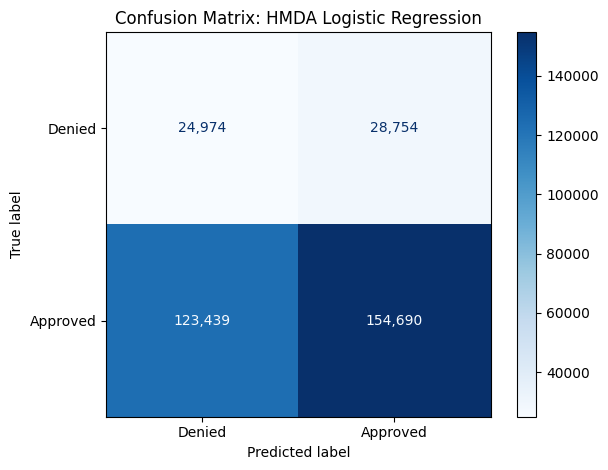

In [94]:
# Create confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# y_test: true labels (0 = denied, 1 = originated)
# y_pred: predicted labels

cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Denied", "Approved"])
disp.plot(cmap="Blues", values_format=",.0f")
plt.title("Confusion Matrix: HMDA Logistic Regression")
plt.grid(False)
plt.tight_layout()
plt.show()

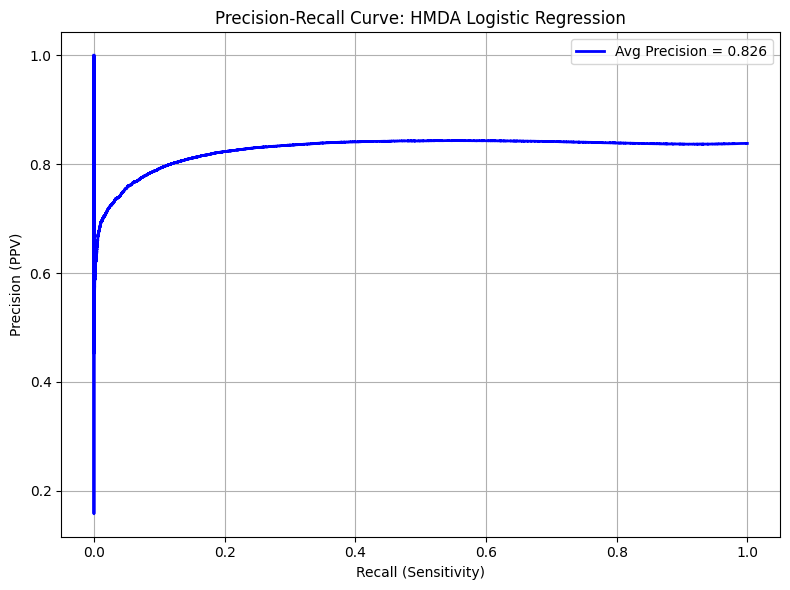

In [95]:
# Precision recall curve
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Get decision scores for the positive class (Loan Originated = 1)
# If you've calibrated your model, use predict_proba. Otherwise:
y_scores = clf.decision_function(X_test_proc)

# Calculate precision-recall pairs
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Average precision is the area under the PR curve
avg_precision = average_precision_score(y_test, y_scores)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color="blue", lw=2, label=f"Avg Precision = {avg_precision:.3f}")
plt.xlabel("Recall (Sensitivity)")
plt.ylabel("Precision (PPV)")
plt.title("Precision-Recall Curve: HMDA Logistic Regression")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [96]:
con.close()